## Data Retrieval and Importing Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
            'https://inshorts.com/en/read/science',
            'https://inshorts.com/en/read/sports']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content,'html.parser')
        
        news_articles = [{'news_headline':headline.find(
        'span',attrs={"itemprop":"headline"}).string,
                         'news_article':article.find(
        'div',attrs={"itemprop":"articleBody"}).string,
                         'news_category':news_category}
                        
                        for headline,article in
                         zip(soup.find_all('div',class_=["news-card-title news-right-box"]),
                            soup.find_all('div',class_=["news-card-content news-right-box"]))
                        
                        ]
        news_data.extend(news_articles)
    df = pd.DataFrame(news_data)
    df = df[['news_headline','news_article','news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,No one can be stopped from using my pic: Scarl...,Talking about her fake pornographic video that...,technology
1,iPhone XS Max explodes in pocket of a man's pa...,A US man named Josh Hillard has claimed his th...,technology
2,Bill Gates calculated slices before cutting ou...,Microsoft Co-founder Bill Gates calculated the...,technology
3,My 7-yr-old stepson allowed 1.5 hrs of screen ...,The 28-year-old billionaire Co-founder and CEO...,technology
4,"Never made New Year's resolution, making one f...",Microsoft Co-founder and world's second riches...,technology
5,Early internet pioneer Lawrence Roberts passes...,Early internet pioneer Lawrence Roberts passed...,technology
6,Apply FDI norms on domestic online firms too: ...,Traders' body CAIT said the Foreign Direct Inv...,technology
7,Waymo self-driving vehicles being vandalised i...,Google spinoff Waymo-owned self-driving vehicl...,technology
8,Centre planning shutdown of sites over fake ne...,The Indian government is reportedly planning a...,technology
9,Google may charge Chinese phone makers for And...,Google has revealed plans to charge Chinese sm...,technology


In [4]:
news_df.news_category.value_counts()

science       25
sports        25
technology    25
Name: news_category, dtype: int64

## Preprocessing of the text

In [5]:
#Importing the necessary libraries for preprocessing of text
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata


nlp = spacy.load('en_core',parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')



    Only loading the 'en' tokenizer.



### Removing HTML Tags

In [6]:
def strip_html_tags(text):
    soup = BeautifulSoup(text,"html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Learning NLP</h2></html>')

'Learning NLP'

### Expand Contractions

In [8]:
def expand_contractions(text,contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join
                                                   (contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub(" ' "," ",expanded_text)
    return expanded_text

expand_contractions("We'll have to expand the contractions I'd think")

'We will have to expand the contractions I would think'

### Remove Special Characters

In [9]:
def remove_special_characters(text,remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else '[^a-zA-z\s]'
    text = re.sub(pattern,'',text)
    return text

remove_special_characters("It is fun to remove special characters! What do you think? 123#@!",remove_digits=True)

'It is fun to remove special characters What do you think '

### Text Lemmatization

In [10]:
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
lem = WordNetLemmatizer()

word = "singing"
    

lem.lemmatize(word,"v")

'sing'

### Text Stemming

In [12]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("Everyday I do yoga to keep myself fit. I even eat healthy food")

'everyday I do yoga to keep myself fit. I even eat healthi food'

### Remove Stopwords

In [13]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The,is,if,a,and are stopwords, which computer is does not understand")

', , , , stopwords , computer not understand'

### Text Normalizer

In [14]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        #if text_lemmatization:
            #doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

### Parts of Speech Tagging

In [15]:
from nltk import word_tokenize, pos_tag

In [16]:
text = "I am learning Natural Language Processing through practical implementation"

tokens = word_tokenize(text)

print(pos_tag(tokens))

[('I', 'PRP'), ('am', 'VBP'), ('learning', 'VBG'), ('Natural', 'NNP'), ('Language', 'NNP'), ('Processing', 'NNP'), ('through', 'IN'), ('practical', 'JJ'), ('implementation', 'NN')]


### Pre-processing and normalizing the news articles scraped

In [17]:
news_df['full_text'] = news_df["news_headline"].map(str)+'. '+news_df["news_article"]

In [18]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text','clean_text']].to_dict()

{'clean_text': 'iphone xs max explodes pocket mans pants us report us man named josh hillard claimed threeweekold iphone xs max smartphone exploded heating back pocket pants december burning skin person put fire fire extinguisher heard yelling josh said added apple inspected phone offered new one',
 'full_text': 'iPhone XS Max explodes in pocket of a man\'s pants in US: Report. A US man named Josh Hillard has claimed his three-week-old iPhone XS Max smartphone exploded after heating up in the back pocket of his pants on December 12, burning his skin. "A person put the fire out with a fire extinguisher because he heard me yelling," Josh said. He added Apple inspected his phone and offered him a new one.'}

### Saving the news articles

In [19]:
news_df.to_csv('news.csv',index=False,encoding='UTF-8')

In [22]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

### Emotion and Sentiment Analyis

In [23]:
from afinn import Afinn

af = Afinn()

In [24]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0
                         else 'negative' if score < 0
                             else 'neutral'
                                 for score in sentiment_scores]

In [37]:
df = pd.DataFrame([list(news_df['news_category']),sentiment_scores,sentiment_category]).T
df.columns = ['news_category','sentiment_score','sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
science                  25.0 -0.12  3.643716 -11.0  0.0  0.0  1.0   6.0
sports                   25.0  2.96  5.028916  -4.0  0.0  2.0  7.0  14.0
technology               25.0 -0.96  6.828128 -14.0 -4.0  0.0  1.0  10.0

### Visualizing the News Sentiment

H:\Anaconda\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


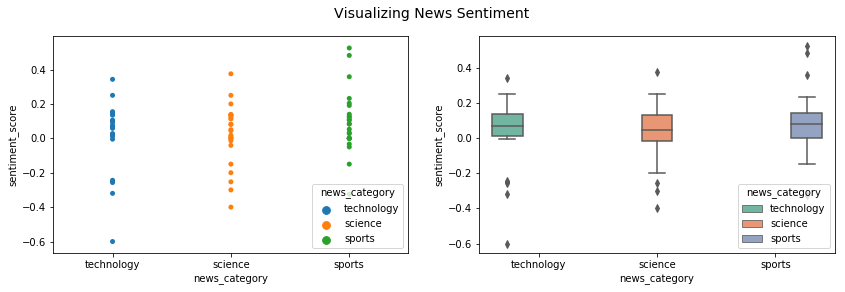

In [35]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
strip_plot = sns.stripplot(x='news_category',y="sentiment_score",
                  hue="news_category",data=df,ax=ax1)
box_plot = sns.boxplot(x='news_category',y="sentiment_score",
                hue="news_category",data=df,palette="Set2",ax=ax2)
t  = f.suptitle('Visualizing News Sentiment',fontsize=14)

H:\Anaconda\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


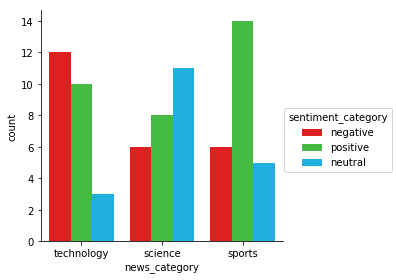

In [27]:
factor_plot = sns.factorplot(x="news_category",hue="sentiment_category",
                            data=df,kind="count",
                            palette={"negative":"#FF0000",
                                    "positive":"#32CD32",
                                    "neutral":"#00BFFF"
                                     })

In [28]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity,3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0
                            else 'negative' if score < 0
                                else 'neutral' 
                                     for score in sentiment_scores_tb]

In [29]:
df = pd.DataFrame([list(news_df['news_category']),sentiment_scores_tb,sentiment_category_tb]).T
df.columns = ['news_category','sentiment_score','sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
science                  25.0  0.02096  0.174235 -0.400 -0.014  0.044  0.129   
sports                   25.0  0.09272  0.179950 -0.325  0.000  0.083  0.140   
technology               25.0  0.01428  0.202528 -0.600  0.013  0.068  0.136   

                      
                 max  
news_category         
science        0.375  
sports         0.525  
technology     0.343

In [30]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,-0.320,negative
1,technology,0.068,positive
2,technology,-0.600,negative
3,technology,0.075,positive
4,technology,0.068,positive


H:\Anaconda\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


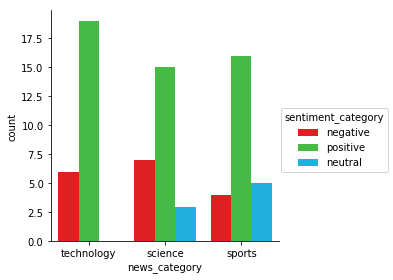

In [31]:
fac_plot = sns.factorplot(x="news_category",hue="sentiment_category",
                         data=df,kind="count",
                         palette={"positive":"#32CD32",
                                  "negative":"#FF0000",
                                    "neutral":"#00BFFF"
                                     })